In [18]:
import torch
from torch import nn
import torchvision.models as models
import torchvision
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset_path = "/content/drive/MyDrive/competitions/digit_recognizer/data" # @param {type:"string"}
batch_size = 1024
test_batch_size = 1
n_epoch = 16
#lr_init = 0.01

if not os.path.exists(dataset_path): # check dataset_path
  print('invalid dataset_path')


In [3]:
class datasets_from_csv():
  def __init__(self, dataset_file, idx=[0]): # read digit data from a csv file
    data = pd.read_csv(dataset_file)
    
    if 'label' in data: # if the dataset is train data
      self.dataset_type = 'train'
      self.inputs = torch.tensor(data.drop('label', axis=1).values).reshape([-1,1,28,28])/255
      self.target = torch.tensor(data['label'].values)
      if len(idx) > 1:
        self.inputs = self.inputs[idx[0] : idx[1]]
        self.target = self.target[idx[0] : idx[1]]
    else: # if the dataset is test data
      self.dataset_type = 'test'
      self.inputs = torch.tensor(data.values).reshape([-1,1,28,28])/255
      if len(idx) > 1:
        self.inputs = self.inputs[idx[0], idx[1]]

  def __getitem__(self, idx):
    if self.dataset_type == 'train':
      return (self.inputs[idx], self.target[idx])
    else:
      return self.inputs[idx]
  
  def __len__(self):
    return len(self.inputs)
    

def make_dataloaders(train_dataset, val_dataset, test_dataset):
  trainloader = torch.utils.data.DataLoader(train_dataset, pin_memory=True, batch_size=batch_size, shuffle=True, drop_last=False)
  valloader = torch.utils.data.DataLoader(val_dataset, pin_memory=True, batch_size=batch_size, shuffle=True, drop_last=False)
  testloader = torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=test_batch_size, shuffle=False, drop_last=False)

  return trainloader, valloader, testloader

In [4]:
class _resblock(nn.Module):
  def __init__(self, input_channel, output_channel, kernel_size=3, stride=1, padding=1):
    super(_resblock, self).__init__()
    self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size, 1, padding)
    self.bn1 = nn.BatchNorm2d(output_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size, stride, padding)
    self.bn2 = nn.BatchNorm2d(output_channel)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)

    return x

class ResNet(nn.Module):
  def __init__(self, input_channel=1, output_channel=10):
    super(ResNet, self).__init__()
    self.input_channel = input_channel
    self.output_channel = output_channel

    self.resblock1 = _resblock(1,  4, 3, 1)
    self.resblock2 = _resblock(4, 4, 3, 1)
    self.resblock3 = _resblock(4, 8, 3, 2)
    self.resblock4 = _resblock(8, 8, 3, 1)
    self.resblock5 = _resblock(8, 16, 3, 2)
    self.resblock6 = _resblock(16, 16, 3, 1)

    self.gamma1 = torch.tensor(0, requires_grad=True)
    self.gamma2 = torch.tensor(0, requires_grad=True)
    self.gamma3 = torch.tensor(0, requires_grad=True)
    self.gamma4 = torch.tensor(0, requires_grad=True)
    self.gamma6 = torch.tensor(0, requires_grad=True)
    self.gamma5 = torch.tensor(0, requires_grad=True)

    self.conv1 = nn.Conv2d(4, 8, 1)
    self.conv2 = nn.Conv2d(8, 16, 1)

    self.fc = nn.Linear(16, 10)
    self.avg_pool = nn.AvgPool2d(2, 2)

    self.global_avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.relu = nn.ReLU()

  
  def forward(self, inputs):
    x = self.gamma1 * self.relu(self.resblock1(inputs)) + inputs
    x = self.gamma2 * self.relu(self.resblock2(x)) + x
    x = self.gamma3 * self.relu(self.resblock3(x)) + self.conv1(self.avg_pool(x))
    x = self.gamma4 * self.relu(self.resblock4(x)) + x
    x = self.gamma5 * self.relu(self.resblock5(x)) + self.conv2(self.avg_pool(x))
    x = self.gamma6 * self.relu(self.resblock6(x)) + x

    x = self.global_avgpool(x)
    x = self.fc(x.reshape(-1, 16))

    return x.reshape(-1, self.output_channel)


In [68]:
def train(model, train_loader, val_loader, n_epoch, lossfn=nn.CrossEntropyLoss()):

  optimizer = torch.optim.Adam(model.parameters())
  pbar_epoch = tqdm(range(n_epoch))
  avg_train_loss = None
  avg_val_loss = None

  for epoch in pbar_epoch:
    train_loss = []
    val_loss = []
    cnt = 0
    pbar_epoch.set_description(f'Epoch')
    pbar_trainloader = tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc='train')
    pbar_valloader = tqdm(enumerate(val_loader), total=len(val_loader), leave=False, desc='validation')

    for i, data in pbar_trainloader:
      optimizer.zero_grad()
      inputs, target = data
      outputs = model(inputs) # estimation
      loss = lossfn(outputs, target) # calculate loss score
      train_loss.append(loss.detach()) # to keep loss score
      loss.backward()
      optimizer.step()
      """if i == 0:
        inputs = inputs[0].numpy()
        inputs = inputs.reshape(28, 28)
        plt.imshow(inputs, cmap = "gray")
        print("target =", target[0], "output =", outputs[0])"""
    
    avg_train_loss = np.average(np.array(train_loss))
    pbar_epoch.set_postfix(train_loss=avg_train_loss, val_loss=avg_val_loss)

    with torch.no_grad():
      for i, data in pbar_valloader:
        inputs, target = data
        outputs = model(inputs) # estimation
        loss = lossfn(outputs, target) # calculate loss score
        val_loss.append(loss.detach()) # to keep loss score
    
    avg_val_loss = np.average(np.array(val_loss))
    pbar_epoch.set_postfix(train_loss=avg_train_loss, val_loss=avg_val_loss)

  return model

In [69]:
train_data_file = os.path.join(dataset_path, 'train.csv')
test_data_file = os.path.join(dataset_path, 'test.csv')

train_dataset = datasets_from_csv(train_data_file, [0, 37800])
val_dataset = datasets_from_csv(train_data_file, [37800, -1])
test_dataset = datasets_from_csv(test_data_file)

train_loader, val_loader, test_loader = make_dataloaders(train_dataset,
                                                         val_dataset, 
                                                         test_dataset)

In [70]:
model = ResNet()

model = train(model, train_loader, val_loader, n_epoch)

  0%|          | 0/16 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/37 [00:00<?, ?it/s]

validation:   0%|          | 0/5 [00:00<?, ?it/s]

In [71]:
def test(model, test_loader, n_show=3):
  output = []
  with torch.no_grad():
    for data in tqdm(test_loader):
      out = np.array(model(data).detach()).flatten()
      print(out)
      out = out.argmax()
      output.append(out)
      data = data.numpy()
      data = data.reshape(28, 28)
      plt.imshow(data, cmap = "gray")
      break

  return np.array(output)

  0%|          | 0/28000 [00:00<?, ?it/s]

[-0.39030513  0.01960701  0.7198274  -0.18696828 -0.14270803  0.5078201
 -0.44398797  0.27606338 -0.09309344  1.0143685 ]


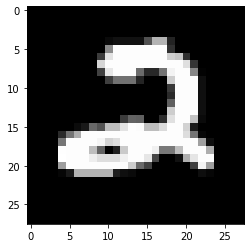

In [72]:
submission = test(model, test_loader)

In [73]:
submission_df = pd.DataFrame(np.array([np.arange(len(submission)), submission]).transpose(), columns=['ImageID', 'Label'])
submission_df.to_csv(os.path.join(dataset_path, 'submission.csv'), index=False)

  0%|          | 0/28000 [00:00<?, ?it/s]

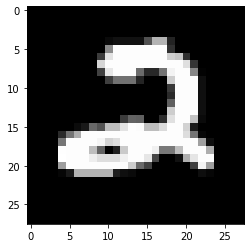

In [74]:
target_idx = 0

with torch.no_grad():
  for i, data in enumerate(tqdm(test_loader)):
    if i == target_idx:
      data = data.numpy()
      data = data.reshape(28, 28)
      plt.imshow(data, cmap = "gray")
      break